# **Stock Portfolio Forecasting and Optimization on S&P500 Using Machine Learning and Search Methods**
<img src="images/pr.jpg" style="width:100%; height:100%;">

## **Abstract**  
Stock market forecasting and portfolio optimization are pivotal challenges in financial decision-making, driven by the volatility and complexity of markets like the S&P500. This project aims to develop an efficient system that predicts stock price trends and optimizes investment portfolios, leveraging historical S&P500 data from 2010 to 2023.  

The solution integrates traditional Machine Learning algorithms (e.g., Random Forest, SVM) for accurate stock price prediction. Furthermore, optimization techniques such as Monte Carlo simulations and genetic algorithms are employed to construct portfolios that maximize returns or minimize risks over a short-term investment horizon.  

By combining predictive analytics with optimization methodologies, this work provides insight for data-driven financial decision-making, promoting effective investment strategies. Ethical considerations and regulatory implications are also addressed, ensuring responsible and practical application in real-world financial contexts.

## **Introduction**
### **Context of the Problem**
The stock market is inherently volatile and complex, making it challenging for investors to forecast stock price trends and optimize investment decisions. Within the S&P500 index, the ability to predict stock movements and construct efficient portfolios is crucial for maximizing returns while managing risks. Traditional methods often fall short in addressing the rapid fluctuations and interdependencies inherent in financial markets, necessitating data-driven, adaptive solutions.

Machine Learning (ML) and Deep Learning (DL) have shown significant potential in addressing these challenges by analyzing large historical datasets, identifying patterns, and predicting trends with improved accuracy. Additionally, portfolio optimization techniques, such as Monte Carlo simulations and genetic algorithms, can help select investments that maximize returns or minimize risks based on forecasted trends. Combining these approaches can streamline decision-making, reduce human bias, and enhance financial performance.

### **Objective of the work**
This project aims to develop a robust framework for predicting stock price trends and optimizing investment portfolios within the S&P500 index. By leveraging ML algorithms models, the objective is to build accurate forecasting systems. These predictions will feed into optimization techniques to create well-balanced investment portfolios over a one-month horizon.

### **Structure of the work**
This notebook is structured as follows:
- Data Acquisition and EDA : We will collect historical price data for all S&P500 stocks from 2010 to January 2024 to build predictive models. Additionally, we will extract relevant financial indices such as moving averages, volatility, and trading volume, which can provide valuable insights into market trends. An Exploratory Data Analysis (EDA) will be conducted to study correlations, detect trends, and evaluate patterns within the data for the predictive modeling process.

- Stock Market Forecasting : This section focuses on developing multi-output forecasting models using traditional Machine Learning techniques such as Random Forest and Support Vector Machines (SVM). These models aim to predict the daily prices of all 500 stocks within the S&P500 index. The performance of each model will be compared using regression metrics such as Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) to determine their effectiveness.

- Model Hyperparameter Tuning : After identifying the most promising models, we will perform hyperparameter tuning to enhance their predictive accuracy further. Techniques such as grid search and randomized search will be employed, targeting optimal configurations for regression metrics. 

- Stock Portfolio Optimization: Building on the forecasting outputs, we will employ advanced optimization techniques, including Monte Carlo simulations and genetic algorithms, to construct efficient investment portfolios. The Monte Carlo simulations will model various potential scenarios to evaluate risk and return distributions, while genetic algorithms will optimize portfolio allocation by iteratively evolving toward the most profitable or least risky configurations. These methods will account for constraints such as diversification, transaction costs, and risk tolerance.

- Discussion and Future Work :  Finally, we will analyze the results, discussing the strengths and limitations of our methodology. This section will provide insights into the practical applications of our approach and suggest potential refinements, such as incorporating alternative datasets (e.g., economic indicators or sentiment analysis) or exploring novel optimization algorithms. Future research directions will aim to enhance both predictive accuracy and portfolio optimization for real-world financial challenges.

## **Data Acquisition and EDA**
As mentioned above, we will extract historical price data for all **current S&P500 stocks**. The list of stocks will be sourced from the S&P500 Wikipedia page, ensuring it reflects the most up-to-date composition of the index. Subsequently, we will utilize the Yahoo Finance API to retrieve the historical data for these stocks, covering the period from 2010 to January 2024. This dataset will include essential information such as daily opening and closing prices, trading volumes, and additional technical indicators. These data points will serve as the foundation for both the forecasting models and the portfolio optimization strategies.

In [1]:
import pandas as pd 

In [5]:
import pandas as pd 
from utils import extract_sp500_companies,extract_stock,process_data
import matplotlib.pyplot as plt
# URL de la página de Wikipedia
df = extract_sp500_companies()
companies = df['Símbolo']
df.head(5)




,Símbolo,Seguridad,Presentación ante la SEC,Sector GICS,Sub-industria GICS,Ubicación de la sede,Fecha de incorporación,Clave de índice central,Fundada
0,MMM,3M,reports,Industriales,Conglomerados Industriales,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industriales,Productos de Edificio,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Cuidado de Salud,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,A123,AbbVie,reports,Cuidado de Salud,Farmacéuticos,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,reports,Tecnología Informática,Consultoría Informática y Otros Servicios,"Dublin, Ireland",2011-07-06,1467373,1989


In [10]:
import utils
from importlib import reload

reload(utils)
from utils import extract_stock,process_data

for stock in companies : 
    raw_stock_data = extract_stock(stock)
    if raw_stock_data is not None : 
        raw_stock_data.to_csv(f"data/raw_stocks/{stock}.csv")
        stock_data = process_data(f"data/raw_stocks/{stock}.csv")
        stock_data.to_csv(f"data/stocks/{stock}.csv")
stock_data.head()
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['A123']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for A123.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for ATVI.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for ABC.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for BRK.B.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for CDAY.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for DISH.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for RE.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FRC']: YFTzM

No data found for FRC.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FLT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for FLT.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for PEAK.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

No data found for PKI.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PXD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


No data found for PXD.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for SBNY.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SIVB']: YFPr

No data found for SIVB.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

No data found for WRK.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,AdjustedClose,Close,High,Low,Open,Volume
0,2013-02-01 00:00:00+00:00,28.409880,31.010000,31.74,30.469999,31.50,66789100
1,2013-02-04 00:00:00+00:00,28.419044,31.020000,31.99,30.760000,31.09,7695400
2,2013-02-05 00:00:00+00:00,28.437372,31.040001,31.98,30.850000,31.25,5013200
3,2013-02-06 00:00:00+00:00,28.428205,31.030001,31.43,30.750000,30.98,2126100
4,2013-02-07 00:00:00+00:00,29.316874,32.000000,32.73,31.000000,31.00,3800800


In [15]:
import os 

print(f"Raw Files Retrieved : {len(os.listdir('data/raw_stocks/'))}, Processed Files : {len(os.listdir('data/stocks/'))}")
raw_folder = "data/raw_stocks/"
raw_files = [os.path.splitext(file)[0] for file in os.listdir(raw_folder) if file.endswith('.csv')]
missing_companies = [company for company in companies if company not in raw_files]# Encontrar las empresas que están en companies pero no en raw_files
print(f"Companies without data : {missing_companies}")


Raw Files Retrieved : 488, Processed Files : 488
Companies without data : ['A123', 'ATVI', 'ABC', 'BRK.B', 'CDAY', 'DISH', 'RE', 'FRC', 'FLT', 'PEAK', 'PKI', 'PXD', 'SBNY', 'SIVB', 'WRK']


Hay 15 compañías de las que no hemos podido obtener datos. Hay que solucionarlo 

In [ ]:

merged.to_csv(f"data/final.csv")


In [ ]:
from utils import join_stock_data,join_macro
import pandas as pd 
data  = join_stock_data()
data['Date']=pd.to_datetime(data['Date']).dt.tz_localize(None) 


series_ids = [
    'GDP',       # Producto Interno Bruto (PIB) de EE. UU.
    'UNRATE',    # Tasa de desempleo
    'CPIAUCSL',  # Índice de Precios al Consumidor (CPI) para todos los consumidores urbanos
    'PAYEMS',    # Nóminas no agrícolas (Nonfarm Payrolls)
    'FEDFUNDS',  # Tasa de fondos federales (Federal Funds Rate)
    'DGS10',     # Rendimiento del bono del Tesoro a 10 años
    'M1SL',      # Oferta monetaria M1
    'M2SL',      # Oferta monetaria M2
    '^GSPC',     # Índice S&P 500
    'INDPRO',    # Índice de Producción Industrial
    'RSAFS',     # Ventas minoristas y servicios alimentarios
    'EXCAUS',    # Tipo de cambio del dólar estadounidense al dólar canadiense
    'BOPGSTB',   # Balanza comercial de bienes y servicios
    'GFDEBTN',   # Deuda del Gobierno Federal de EE. UU.
    'FGEXPND',   # Gasto total del gobierno federal
    'PCEPI',     # Índice de Precios de Gastos de Consumo Personal
    'PPIACO',    # Índice de Precios al Productor
    'UMCSENT'    # Índice de Confianza del Consumidor de la Universidad de Michigan,
    '^IXIC',     # NASDAQ
    '^RUT',
    '^STOXX50E',
    '^FTSE',
    'CL=F',
    'SI=F',
    'GC=F',
    '^HSI',
    'NG=F',
    'ZC=F',
    'EURUSD=X',
    '^VIX'
    ]
start = '2010-01-01'
end = '2024-01-31'
dataframes=[data]
data_macro=join_macro(series_ids,start,end)
print(data.columns)
print(data_macro.columns)

merged = pd.merge(data, data_macro, on='Date', how='outer')

# Opcional: Ordenamos el resultado por stock_symbol y Date para claridad
merged = merged.sort_values(by=['stock_symbol', 'Date']).reset_index(drop=True)

# Mostrar el DataFrame resultante
display(merged)
# # Reorganizamos para replicar las filas de 'df2' por clase de 'df1'
# # Llenamos NaN en las clases faltantes y replicamos por cada clase
# clases_unicas = df1['stock_symbol'].unique()
# df_resultado = (
#     df_merge
#     .merge(pd.DataFrame({'stock_symbol': clases_unicas}), how='cross')  # Añade cada clase a todas las fechas
#     .sort_values(by=['stock_symbol', 'fecha'])  # Ordena por clase y fecha
#     .reset_index(drop=True)  # Reinicia los índices
# )


# display(final_df)

[*********************100%***********************]  1 of 1 completed


Serie ^GSPC ha fallado


[*********************100%***********************]  1 of 1 completed

Serie UMCSENT^IXIC ha fallado


Serie ^RUT ha fallado


[*********************100%***********************]  1 of 1 completed


Serie ^STOXX50E ha fallado


[*********************100%***********************]  1 of 1 completed


Serie ^FTSE ha fallado


[*********************100%***********************]  1 of 1 completed


Serie CL=F ha fallado


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Serie SI=F ha fallado



[*********************100%***********************]  1 of 1 completed

Serie GC=F ha fallado



[*********************100%***********************]  1 of 1 completed

Serie ^HSI ha fallado


Serie NG=F ha fallado


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Serie ZC=F ha fallado


Serie EURUSD=X ha fallado
Index(['Date', 'AdjustedClose', 'Close', 'High', 'Low', 'Open', 'Volume',
       'stock_symbol'],
      dtype='object')
Index(['Date', 'GDP', 'UNRATE', 'CPIAUCSL', 'PAYEMS', 'FEDFUNDS', 'DGS10',
       'M1SL', 'M2SL', 'INDPRO', 'RSAFS', 'EXCAUS', 'BOPGSTB', 'GFDEBTN',
       'FGEXPND', 'PCEPI', 'PPIACO'],
      dtype='object')


,Date,AdjustedClose,Close,High,Low,Open,Volume,stock_symbol,GDP,UNRATE,...,M1SL,M2SL,INDPRO,RSAFS,EXCAUS,BOPGSTB,GFDEBTN,FGEXPND,PCEPI,PPIACO
0,2010-01-04,20.053028,22.389128,22.625179,22.267525,22.453505,3815561.0,A,14980.193,9.8,...,1699.8,8527.6,89.5046,346724.0,1.0572,-41504.0,13201792.0,3745.711,90.134,181.000
1,2010-01-05,19.835203,22.145924,22.331903,22.002861,22.324751,4186031.0,A,14980.193,9.8,...,1699.8,8527.6,89.5046,346724.0,1.0572,-41504.0,13201792.0,3745.711,90.134,181.000
2,2010-01-06,19.764723,22.067240,22.174536,22.002861,22.067240,3243779.0,A,14980.193,9.8,...,1699.8,8527.6,89.5046,346724.0,1.0572,-41504.0,13201792.0,3745.711,90.134,181.000
3,2010-01-07,19.739101,22.038628,22.045780,21.816881,22.017166,3095172.0,A,14980.193,9.8,...,1699.8,8527.6,89.5046,346724.0,1.0572,-41504.0,13201792.0,3745.711,90.134,181.000
4,2010-01-08,19.732695,22.031473,22.067240,21.745352,21.917025,3733918.0,A,14980.193,9.8,...,1699.8,8527.6,89.5046,346724.0,1.0572,-41504.0,13201792.0,3745.711,90.134,181.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659661,2024-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28624.069,3.7,...,17934.4,20725.9,101.4830,695631.0,1.3423,-66399.0,34586533.0,6772.827,122.115,251.306
1659662,2024-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28624.069,3.7,...,17934.4,20725.9,101.4830,695631.0,1.3423,-66399.0,34586533.0,6772.827,122.115,251.306
1659663,2024-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28624.069,3.7,...,17934.4,20725.9,101.4830,695631.0,1.3423,-66399.0,34586533.0,6772.827,122.115,251.306
1659664,2024-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28624.069,3.7,...,17934.4,20725.9,101.4830,695631.0,1.3423,-66399.0,34586533.0,6772.827,122.115,251.306


In [2]:
# Hacemos un merge basado en la columna 'Date' usando un outer join

merged.to_csv(f"data/final.csv")


In [14]:
data.shape
df = data

In [15]:
df

,Date,AdjustedClose,Close,High,Low,Open,Volume,stock_symbol
0,2010-01-04 00:00:00+00:00,20.053024,22.389128,22.625179,22.267525,22.453505,2.782205,A
1,2010-01-05 00:00:00+00:00,19.835205,22.145924,22.331903,22.002861,22.324751,2.787925,A
2,2010-01-06 00:00:00+00:00,19.764719,22.067240,22.174536,22.002861,22.067240,2.772104,A
3,2010-01-07 00:00:00+00:00,19.739101,22.038628,22.045780,21.816881,22.017166,2.769168,A
4,2010-01-08 00:00:00+00:00,19.732689,22.031473,22.067240,21.745352,21.917025,2.780865,A
...,...,...,...,...,...,...,...,...
1658059,2024-01-24 00:00:00+00:00,184.663101,186.070007,189.699997,185.929993,188.809998,2.735926,ZTS
1658060,2024-01-25 00:00:00+00:00,185.903641,187.320007,187.529999,185.309998,185.529999,2.756457,ZTS
1658061,2024-01-26 00:00:00+00:00,190.071899,191.520004,192.880005,188.970001,189.210007,2.736015,ZTS
1658062,2024-01-29 00:00:00+00:00,191.302521,192.759995,193.000000,189.960007,191.360001,2.729699,ZTS


,Date,AdjustedClose,Close,High,Low,Open,Volume,stock_symbol
0,2010-01-04 00:00:00+00:00,20.053024,22.389128,22.625179,22.267525,22.453505,0.613021,A
1,2010-01-05 00:00:00+00:00,19.835205,22.145924,22.331903,22.002861,22.324751,0.613372,A
2,2010-01-06 00:00:00+00:00,19.764719,22.067240,22.174536,22.002861,22.067240,0.612399,A
3,2010-01-07 00:00:00+00:00,19.739101,22.038628,22.045780,21.816881,22.017166,0.612218,A
4,2010-01-08 00:00:00+00:00,19.732689,22.031473,22.067240,21.745352,21.917025,0.612939,A


Date             0
AdjustedClose    0
Close            0
High             0
Low              0
Open             0
Volume           0
stock_symbol     0
dtype: int64
Duplicados:  0


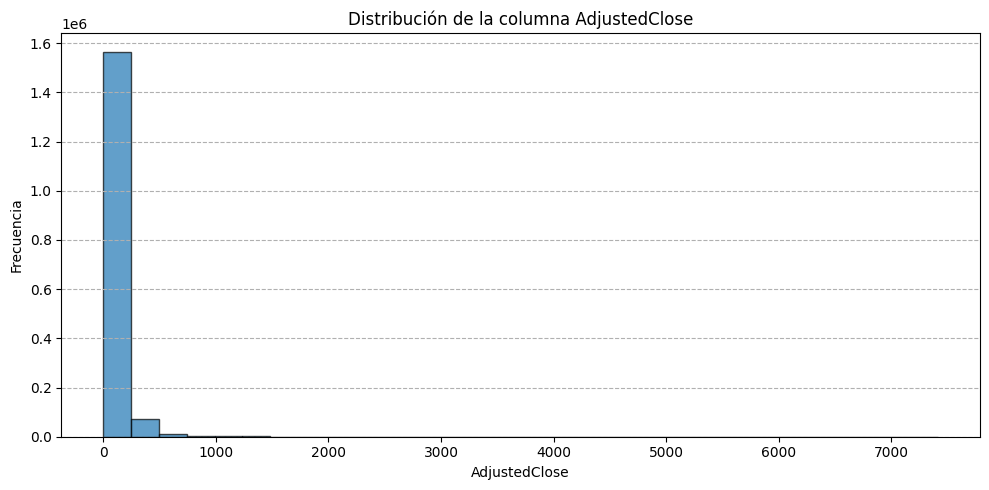

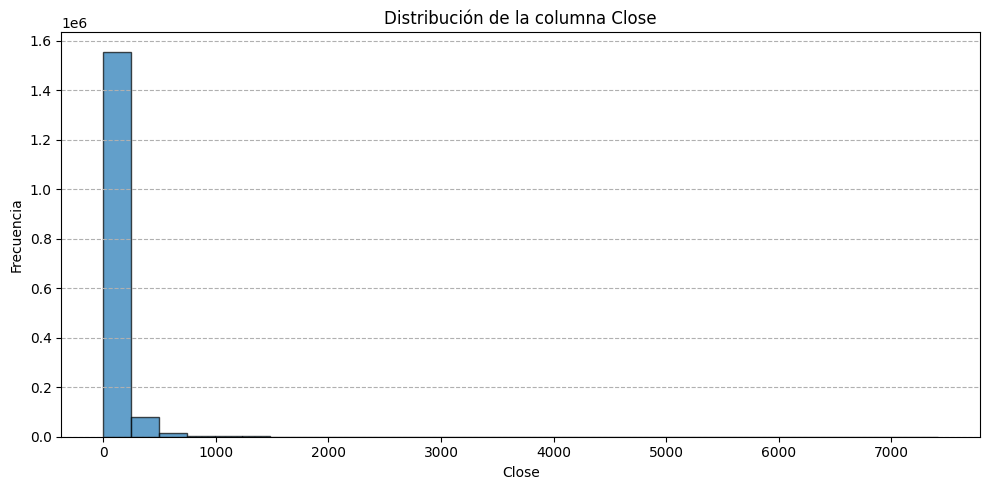

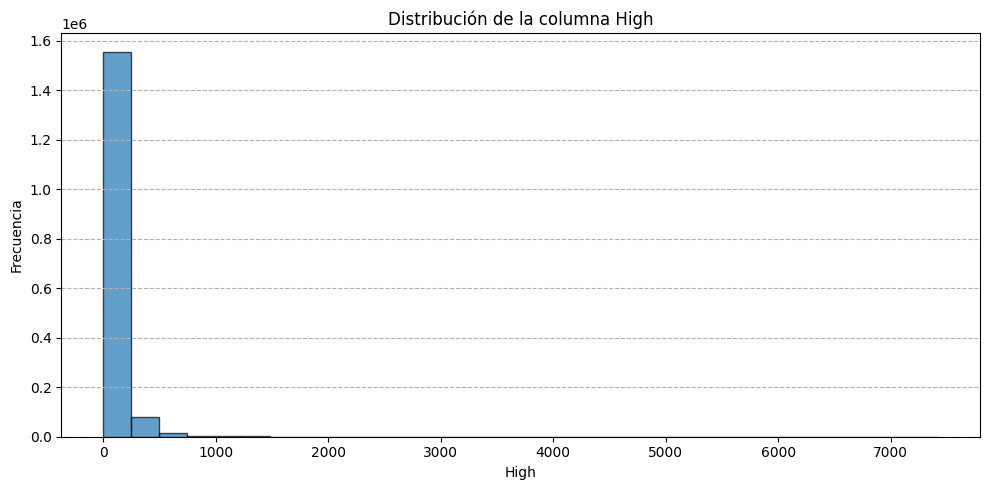

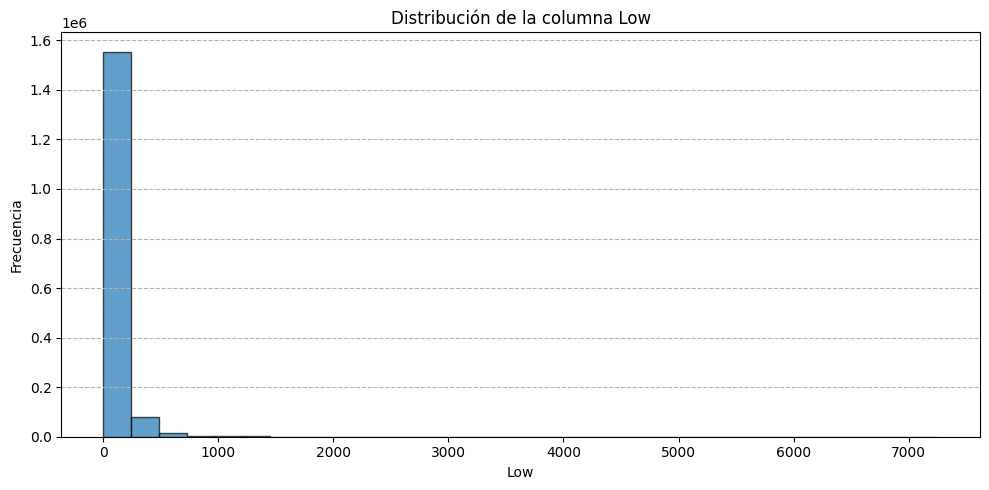

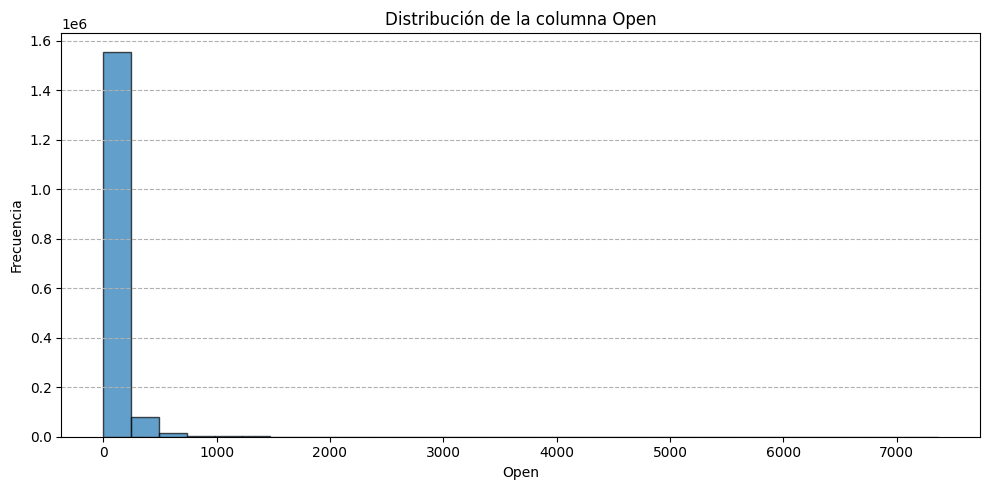

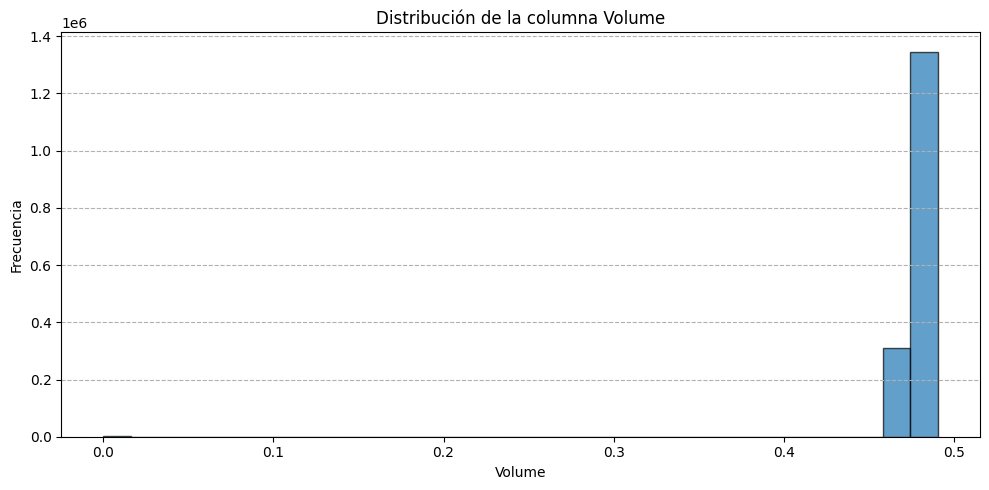

Index(['AdjustedClose', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


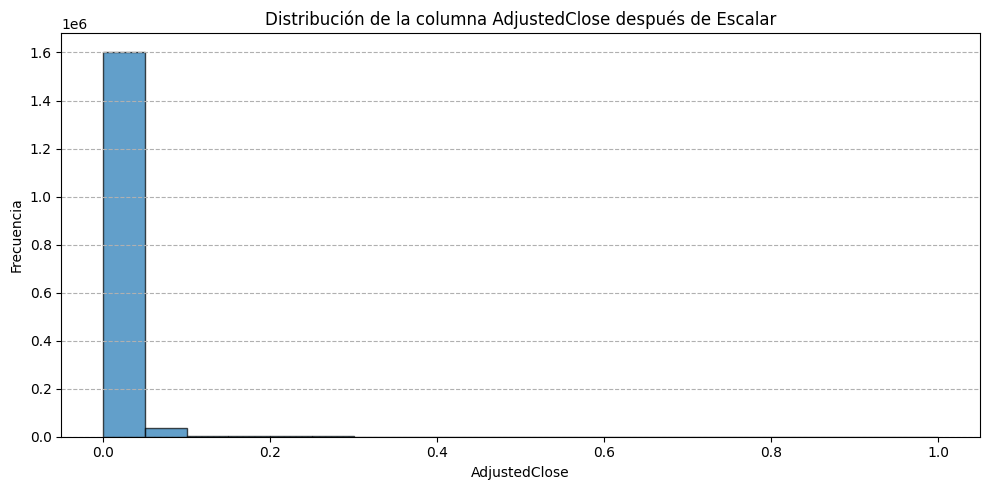

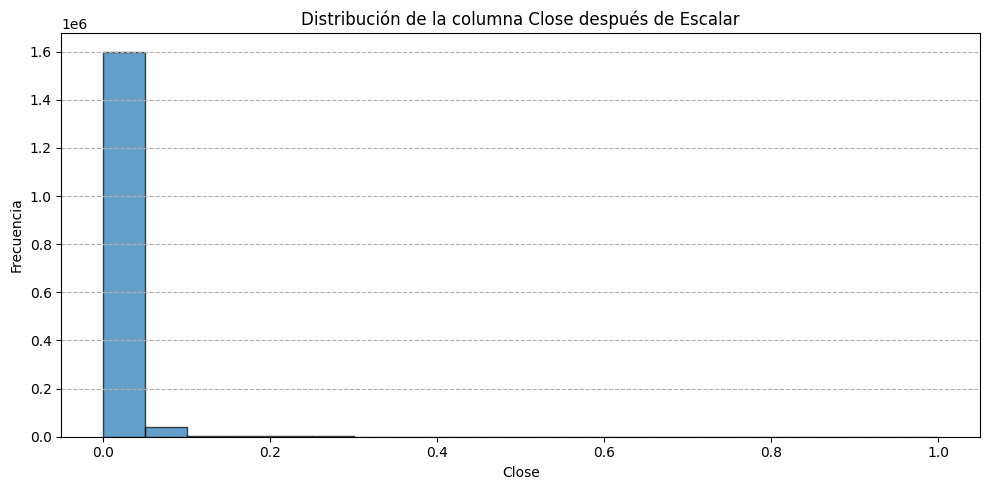

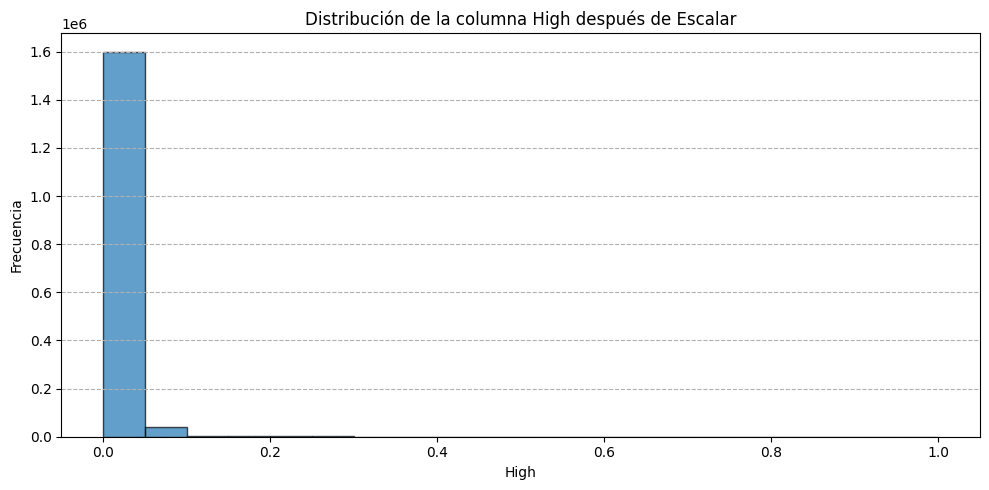

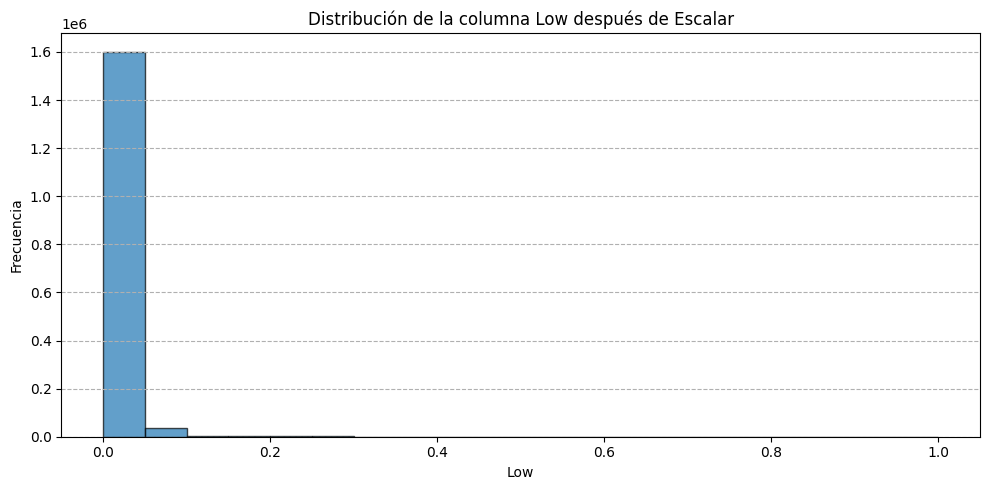

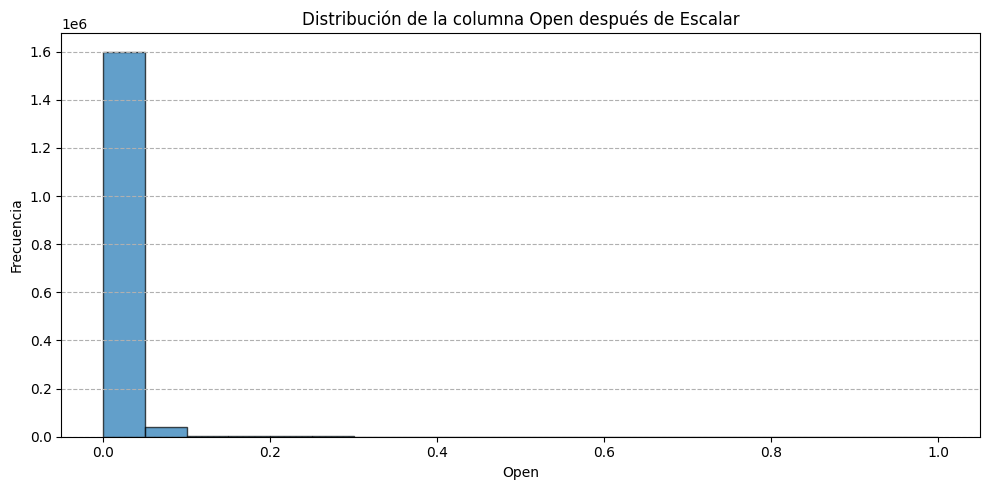

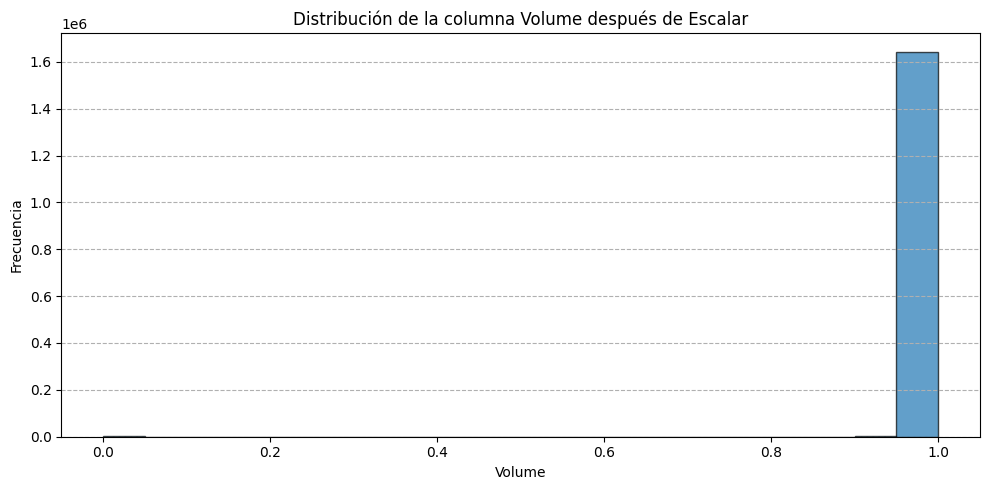

In [19]:
display(df.head())
from sklearn.preprocessing import MinMaxScaler
print(df.isnull().sum())

print('Duplicados: ',df.duplicated().sum())


# Iterar sobre todas las columnas menos 'Date'
for columna in df.columns:
    if columna not in ['Date',"stock_symbol"] :
        # Verificar valores no numéricos en la columna
        non_numeric_values = df[columna][~df[columna].apply(lambda x: isinstance(x, (int, float)))]
        # Convertir la columna a tipo numérico, forzando los errores a NaN
        df[columna] = pd.to_numeric(df[columna], errors='coerce')

# Dividir train y test  
import numpy as np
df['Volume'] = np.log1p(df['Volume'])  # log1p para evitar problemas con valores cercanos a 0

# Crear una lista con los nombres de cada columna numérica, excluyendo "Date" y "Volume"
columnas_numericas = [col for col in df.columns if col not in ['Date',"stock_symbol"]]

# Generar un histograma para cada columna numérica
for columna in columnas_numericas:
    plt.figure(figsize=(10, 5))
    plt.hist(df[columna].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"Distribución de la columna {columna}")
    plt.xlabel(columna)
    plt.ylabel("Frecuencia")
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

train=df[df['Date']<'2024-01-01']
test=df[df['Date']>='2024-01-01']

train=train.drop(columns=['Date',"stock_symbol"])
test=test.drop(columns=['Date',"stock_symbol"])

scaler=MinMaxScaler()#Usamos minmax debido a que los datos tienen un dsitribución multimodal con varios patrones, Min Max Scaler preserva esto  

train_scaled=scaler.fit_transform(train)
test_scaled=scaler.transform(test)

train=pd.DataFrame(train_scaled,columns=columnas_numericas)
test = pd.DataFrame(test_scaled, columns=columnas_numericas)

print(train.columns)

for columna in columnas_numericas:
    plt.figure(figsize=(10, 5))
    plt.hist(train[columna], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f"Distribución de la columna {columna} después de Escalar")
    plt.xlabel(columna)
    plt.ylabel("Frecuencia")
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()


In [ ]:
import sklearn
import xgboost as xgb
import numpy as np
import pandas as pd

print(sklearn.__version__)


# Ejemplo de datos (esto es solo un esquema)
# X_train tendría dimensiones [n_samples, n_features], donde n_samples es el número de días y n_features son las características.
# Y_train tendría dimensiones [n_samples, 500], donde 500 es el número de acciones que estás prediciendo.

X_train = np.random.rand(1000, 10)  # Ejemplo: 1000 días de datos, 10 características para cada día
Y_train = np.random.rand(1000, 500)  # Predicción de 500 acciones para esos 1000 días

# Crear el modelo de Gradient Boosting (XGBoost)
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)

# Entrenar el modelo
model.fit(X_train, Y_train)

# Hacer predicciones para un nuevo conjunto de datos
X_test = np.random.rand(1, 10)  # Un solo día de prueba con 10 características
predictions = model.predict(X_test)  # Salida: un vector de 500 precios para las 500 acciones

print(predictions)


1.5.2
[[0.92346686 0.7953855  0.43536776 0.52353084 0.45549384 0.531909
  0.32030082 0.41959494 0.41419482 0.72934514 0.3413234  0.3359825
  0.4661119  0.4601022  0.74042153 0.54543436 0.44331527 0.51455545
  0.4934612  0.6120811  0.45319074 0.56199515 0.34445274 0.5544125
  0.5511384  0.37831652 0.53285086 0.34925583 0.30053276 0.41500953
  0.4919683  0.6147646  0.4048801  0.6701909  0.5257274  0.38978577
  0.4866139  0.41491455 0.38446873 0.6061277  0.57104516 0.49358904
  0.66116816 0.57412887 0.5227407  0.6901123  0.47126338 0.64002055
  0.6158423  0.4400281  0.55263615 0.46241367 0.4307943  0.48177186
  0.43908727 0.3495685  0.29237294 0.5364167  0.30666444 0.5498577
  0.2702319  0.6120869  0.568894   0.2537671  0.7156332  0.4538946
  0.42931738 0.64559865 0.4647227  0.57842994 0.38317898 0.4387498
  0.36938566 0.57032275 0.6445587  0.5039969  0.37459707 0.61019397
  0.45795774 0.37512037 0.5779482  0.5915979  0.54331607 0.5793126
  0.7318259  0.60979074 0.38821724 0.4687471  0.55